# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Project Setup

In [320]:
# all import statements needed for the project, for example:

import os

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
from sqlalchemy import text
from sqlalchemy import create_engine
import numpy as np

In [5]:
# any constants you might need; some have been added for you, and 
# some you need to fill in

TLC_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = ""
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = ""

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project_1.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [7]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### Load Taxi Zones

In [11]:
#!pip install geopandas
import geopandas as gpd

In [12]:
def load_taxi_zones(shapefile):
    '''
    This function reads the taxi_zones file and change the location into latitude and longitude format
    '''
    data = gpd.read_file(shapefile)
    
    # change coordinate system since we need to compare to (40.560445, -74.242330) and (40.908524, -73.717047)
    data = data.to_crs(epsg=4326) 

    # calculating latitude and longitude using given geo data
    data["latitude"] = data.geometry.centroid.y
    data["longitude"] = data.geometry.centroid.x
    return data


In [15]:
taxi_zones = load_taxi_zones("taxi_zones.shp")
taxi_zones

C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3344000312.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data["latitude"] = data.geometry.centroid.y
C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3344000312.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data["longitude"] = data.geometry.centroid.x


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,latitude,longitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.695, -74.18449 40.6951,...",40.691831,-74.174000
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",40.616745,-73.831299
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",40.864474,-73.847422
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",40.723752,-73.976968
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",40.552659,-74.188484
...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((-73.85107 40.91037, -73.85207 40.909...",40.897932,-73.852215
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((-73.90175 40.76078, -73.90147 40.759...",40.744235,-73.906306
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",40.709139,-74.013023
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",40.775932,-73.946510


In [16]:
def lookup_coords_for_taxi_zone_id(zone_loc_id, loaded_taxi_zones):
    '''
    This function load takes id and the loaded taxi zone df and return the id's corresponding lat,lon pair
    '''
    zone = loaded_taxi_zones[loaded_taxi_zones["LocationID"] == zone_loc_id]
    if zone.empty:
        return 0.0,0.0
        
    lat = zone["latitude"].values[0]
    lon= zone["longitude"].values[0]
    return lat,lon

def get_coords(id):
    return lookup_coords_for_taxi_zone_id(id, taxi_zones)
    

   

### Calculate Sample Size

In [20]:
import math

def calculate_sample_size(population):
    '''
    According to the Youtube video
    https://www.youtube.com/watch?v=dRYKi6pIUaU
    Our sample size should be n1 = 385/(1+ 384/N) where N is our poplulation size
    385 is a constant calculated by the video
    '''
    return math.ceil(385/(1+384/population))

'''
test 
'''
calculate_sample_size(2000)

323

### Common Functions

The cells below takes the TLC_URL linke to obtain a list of all yellow cab and fhvhv data parquet links.

### get_all_urls_from_tlc_page(taxi_page)

Str_of_URL -> Str_of_html_content

get_all_urls_from_tlc_page takes the TLC_URL link and return its html content for filter_parquet_urls to continue



### filter_parquet_urls(all_urls)

Str_of_html_content -> List_of_parquet_links

filter_parquet_urls takes the html content returned by previous function and return a list of all yellow cabs and fhvhv cars' link

In [24]:
def get_all_urls_from_tlc_page(taxi_page):
    response = requests.get(taxi_page)
    html = response.content
    return html

all_urls = get_all_urls_from_tlc_page(TLC_URL)


In [25]:
def filter_parquet_urls(all_urls):
    soup = bs4.BeautifulSoup(all_urls, "html.parser")
    yellow_a_tags = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    HVFHV_a_tags = soup.find_all("a", attrs={"title": "High Volume For-Hire Vehicle Trip Records"})
    all_a_tags = yellow_a_tags + HVFHV_a_tags
    return [a["href"] for a in all_a_tags]

all_parquet_urls = filter_parquet_urls(all_urls)



In [27]:
import re

### select_parquet(all_urls)

List_of_parquet -> List_of_parquet

select_parquet(all_urls) takes a list of parquets and filter out all parquets not in the Jan 2020 - Aug 2024 period

In [31]:
def select_parquet(all_urls):
    result =[]
    for i in range(len(all_urls)):
        curr_url = all_urls[i]
        pattern = r"(\d{4})-(\d{2})"
        match = re.search(pattern, curr_url)
        year_str = int(match.group(1))
        month_str = int(match.group(2))
        if (year_str < 2020):
            continue
        if (year_str >= 2024 and month_str > 8):
            continue
        result += [curr_url]       
    return result



In [33]:
required_parquests = select_parquet(all_parquet_urls)


### select_yellow(urls)

List_of_parquet -> List_of_parquet

select_yellow(urls) takes the parquet filterd by select_parquet and returns all the yellow cabs link as a list

In [36]:
def select_yellow(urls):
    result =[]
    for i in range(len(urls)):
        curr_url = urls[i]
        if not isinstance(curr_url, str):
            continue
        pattern = r"yellow"
        match = re.search(pattern, curr_url)
        if match is None:
            continue
        else: 
            result += [curr_url]       
    return result

In [38]:
required_parquests
yellow_cabs = select_yellow(required_parquests)


### select_fhvhv(urls)

List_of_parquet -> List_of_parquet

Same as select_yellow, but it returns fhvhv links.

In [41]:
def select_fhvhv(urls):
    result =[]
    for i in range(len(urls)):
        curr_url = urls[i]
        if not isinstance(curr_url, str):
            continue
        pattern = r"fhvhv"
        match = re.search(pattern, curr_url)
        if match is None:
            continue
        else: 
            result += [curr_url]       
    return result

In [43]:
required_parquests
fhvhv_cabs = select_fhvhv(required_parquests)


### download_one(url, save_name)

Str_of_parquet ->None

Output: 1.message of download result
        2.download a file

download_one(url, save_name) takes a parquet link of yellow cab or fhvhv, then write the data into a local file named save_name. It prints a message if download is successful and raise a http error otherwise

In [46]:
def download_one(url, save_name):
    response = requests.get(url, stream=True)
    response.raise_for_status()  

    with open(save_name, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                file.write(chunk)

    print(f"File downloaded successfully as {save_name}")
    return None


In [48]:
download_one('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-01.parquet','fhvhv_tripdata_2024-01.parquet')
df = pd.read_parquet('fhvhv_tripdata_2024-01.parquet')
df

File downloaded successfully as fhvhv_tripdata_2024-01.parquet


,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2024-01-01 00:21:47,2024-01-01 00:25:06,2024-01-01 00:28:08,2024-01-01 01:05:39,161,158,2.83,...,4.05,2.75,0.0,0.00,40.18,N,N,N,N,N
1,HV0003,B03404,B03404,2024-01-01 00:10:56,2024-01-01 00:11:08,2024-01-01 00:12:53,2024-01-01 00:20:05,137,79,1.57,...,0.89,2.75,0.0,0.00,6.12,N,N,N,N,N
2,HV0003,B03404,B03404,2024-01-01 00:20:04,2024-01-01 00:21:51,2024-01-01 00:23:05,2024-01-01 00:35:16,79,186,1.98,...,1.60,2.75,0.0,0.00,9.47,N,N,N,N,N
3,HV0003,B03404,B03404,2024-01-01 00:35:46,2024-01-01 00:39:59,2024-01-01 00:41:04,2024-01-01 00:56:34,234,148,1.99,...,1.52,2.75,0.0,0.00,11.35,N,N,N,N,N
4,HV0003,B03404,B03404,2024-01-01 00:48:19,2024-01-01 00:56:23,2024-01-01 00:57:21,2024-01-01 01:10:02,148,97,2.65,...,3.43,2.75,0.0,0.00,28.63,N,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19663925,HV0003,B03404,B03404,2024-01-31 23:24:46,2024-01-31 23:26:11,2024-01-31 23:28:08,2024-01-31 23:32:13,79,113,0.65,...,0.81,2.75,0.0,1.00,5.39,N,N,N,N,N
19663926,HV0003,B03404,B03404,2024-01-31 23:33:02,2024-01-31 23:34:07,2024-01-31 23:34:19,2024-02-01 00:07:53,113,248,13.32,...,3.19,2.75,0.0,0.00,36.43,N,N,N,N,N
19663927,HV0003,B03404,B03404,2024-01-31 23:28:59,2024-01-31 23:30:51,2024-01-31 23:31:14,2024-01-31 23:38:18,161,50,1.31,...,0.89,2.75,0.0,0.00,5.71,N,N,N,N,N
19663928,HV0003,B03404,B03404,2024-01-31 23:39:00,2024-01-31 23:41:03,2024-01-31 23:41:45,2024-01-31 23:52:40,246,163,1.57,...,1.62,2.75,0.0,4.62,8.54,N,N,N,N,N


### data download

The cells below using for loops to call download_one repeatedly to download all yellow cabs and fhvhv parquet data. It uses url.strip() because sometimes we might have a white space in the end of input parquet link which might cause 403 error

In [32]:
uber_urls = [] #create list of urls for cleanning all the datasets
for i in fhvhv_cabs:
    url = i
    url = url.strip()
    pattern = r"fhvhv_tripdata_\d{4}-\d{2}\.parquet"
    match = re.search(pattern, url)
    save_name = match.group()
    download_one(url, save_name)
    uber_urls.append(save_name)

File downloaded successfully as fhvhv_tripdata_2024-01.parquet
File downloaded successfully as fhvhv_tripdata_2024-02.parquet
File downloaded successfully as fhvhv_tripdata_2024-03.parquet
File downloaded successfully as fhvhv_tripdata_2024-04.parquet
File downloaded successfully as fhvhv_tripdata_2024-05.parquet
File downloaded successfully as fhvhv_tripdata_2024-06.parquet
File downloaded successfully as fhvhv_tripdata_2024-07.parquet
File downloaded successfully as fhvhv_tripdata_2024-08.parquet
File downloaded successfully as fhvhv_tripdata_2023-01.parquet
File downloaded successfully as fhvhv_tripdata_2023-02.parquet
File downloaded successfully as fhvhv_tripdata_2023-03.parquet
File downloaded successfully as fhvhv_tripdata_2023-04.parquet
File downloaded successfully as fhvhv_tripdata_2023-05.parquet
File downloaded successfully as fhvhv_tripdata_2023-06.parquet
File downloaded successfully as fhvhv_tripdata_2023-07.parquet
File downloaded successfully as fhvhv_tripdata_2023-08.

In [33]:
taxi_urls = [] #create list of urls for cleanning all the datasets
for i in yellow_cabs:
    url = i
    url = url.strip()
    pattern = r"yellow_tripdata_\d{4}-\d{2}\.parquet"
    match = re.search(pattern, url)
    save_name = match.group()
    download_one(url, save_name)
    taxi_urls.append(save_name)

File downloaded successfully as yellow_tripdata_2024-01.parquet
File downloaded successfully as yellow_tripdata_2024-02.parquet
File downloaded successfully as yellow_tripdata_2024-03.parquet
File downloaded successfully as yellow_tripdata_2024-04.parquet
File downloaded successfully as yellow_tripdata_2024-05.parquet
File downloaded successfully as yellow_tripdata_2024-06.parquet
File downloaded successfully as yellow_tripdata_2024-07.parquet
File downloaded successfully as yellow_tripdata_2024-08.parquet
File downloaded successfully as yellow_tripdata_2023-01.parquet
File downloaded successfully as yellow_tripdata_2023-02.parquet
File downloaded successfully as yellow_tripdata_2023-03.parquet
File downloaded successfully as yellow_tripdata_2023-04.parquet
File downloaded successfully as yellow_tripdata_2023-05.parquet
File downloaded successfully as yellow_tripdata_2023-06.parquet
File downloaded successfully as yellow_tripdata_2023-07.parquet
File downloaded successfully as yellow_t

In [34]:
taxi_urls

['yellow_tripdata_2024-01.parquet',
 'yellow_tripdata_2024-02.parquet',
 'yellow_tripdata_2024-03.parquet',
 'yellow_tripdata_2024-04.parquet',
 'yellow_tripdata_2024-05.parquet',
 'yellow_tripdata_2024-06.parquet',
 'yellow_tripdata_2024-07.parquet',
 'yellow_tripdata_2024-08.parquet',
 'yellow_tripdata_2023-01.parquet',
 'yellow_tripdata_2023-02.parquet',
 'yellow_tripdata_2023-03.parquet',
 'yellow_tripdata_2023-04.parquet',
 'yellow_tripdata_2023-05.parquet',
 'yellow_tripdata_2023-06.parquet',
 'yellow_tripdata_2023-07.parquet',
 'yellow_tripdata_2023-08.parquet',
 'yellow_tripdata_2023-09.parquet',
 'yellow_tripdata_2023-10.parquet',
 'yellow_tripdata_2023-11.parquet',
 'yellow_tripdata_2023-12.parquet',
 'yellow_tripdata_2022-01.parquet',
 'yellow_tripdata_2022-02.parquet',
 'yellow_tripdata_2022-03.parquet',
 'yellow_tripdata_2022-04.parquet',
 'yellow_tripdata_2022-05.parquet',
 'yellow_tripdata_2022-06.parquet',
 'yellow_tripdata_2022-07.parquet',
 'yellow_tripdata_2022-08.pa

In [35]:
taxi_urls

['yellow_tripdata_2024-01.parquet',
 'yellow_tripdata_2024-02.parquet',
 'yellow_tripdata_2024-03.parquet',
 'yellow_tripdata_2024-04.parquet',
 'yellow_tripdata_2024-05.parquet',
 'yellow_tripdata_2024-06.parquet',
 'yellow_tripdata_2024-07.parquet',
 'yellow_tripdata_2024-08.parquet',
 'yellow_tripdata_2023-01.parquet',
 'yellow_tripdata_2023-02.parquet',
 'yellow_tripdata_2023-03.parquet',
 'yellow_tripdata_2023-04.parquet',
 'yellow_tripdata_2023-05.parquet',
 'yellow_tripdata_2023-06.parquet',
 'yellow_tripdata_2023-07.parquet',
 'yellow_tripdata_2023-08.parquet',
 'yellow_tripdata_2023-09.parquet',
 'yellow_tripdata_2023-10.parquet',
 'yellow_tripdata_2023-11.parquet',
 'yellow_tripdata_2023-12.parquet',
 'yellow_tripdata_2022-01.parquet',
 'yellow_tripdata_2022-02.parquet',
 'yellow_tripdata_2022-03.parquet',
 'yellow_tripdata_2022-04.parquet',
 'yellow_tripdata_2022-05.parquet',
 'yellow_tripdata_2022-06.parquet',
 'yellow_tripdata_2022-07.parquet',
 'yellow_tripdata_2022-08.pa

### Process Taxi Data

In [147]:
def get_and_clean_taxi_month(url):
    '''
    This function does the follows:
        1. Drop rows with null values in all columns
        2. Ensure dropoff_datetime > pickup_datetime > request_datetime
        3. Filter rows with invalid or negative location IDs
        4. Remove rows with zero or negative trip durations
        5. Remove location outside of  (40.560445, -74.242330) and (40.908524, -73.717047).
    '''
    
    # Keep only the necessary columns
    df1=pd.read_parquet(url)
    poplulation = df1.shape[0]
    sample_size = calculate_sample_size(poplulation)
    print(f"population is {poplulation} and calculated sample size is {sample_size}")
    #random_state let the function get the same result of the random rows from the dataset
    df1 = df1.sample(n=sample_size, random_state=5)
    
    df1.columns = (
        df1.columns
        .str.strip()               
        .str.lower()               
        .str.replace(' ', '_')     
        .str.replace(r'\W+', '_')  
    )
    
    columns_to_keep = [
        "tpep_pickup_datetime", "tpep_dropoff_datetime",
        "trip_distance", "pulocationid", "dolocationid", "fare_amount",	"extra",	
        "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "congestion_surcharge", "airport_fee"
    ]
    yellow_data = df1[columns_to_keep]
    
    yellow_data = yellow_data.rename(columns={
        "vendorid": "trip_id",
        "tpep_pickup_datetime": "pickup_time",
        "tpep_dropoff_datetime": "dropoff_time",
        "pulocationid": "pick_up_location",
        "dolocationid": "drop_off_location"
    })
    #replace NaN with 0 for airport_fee
    yellow_data['airport_fee'] = yellow_data['airport_fee'].fillna(0)

    #make sure pickup_time in proper datetime format
    yellow_data['pickup_time'] = pd.to_datetime(yellow_data['pickup_time'], errors='coerce')
    yellow_data['dropoff_time'] = pd.to_datetime(yellow_data['dropoff_time'], errors='coerce')
                                                                  
    # 1. Drop rows with null values in all columns
    all_taxi_columns = ["pickup_time",	"dropoff_time",	"trip_distance", "pick_up_location","drop_off_location","fare_amount",	"extra",	
         "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount","congestion_surcharge","airport_fee"]
    yellow_data = yellow_data.dropna(subset=all_taxi_columns)
    
    # 2. Ensure dropoff_datetime > pickup_datetime > request_datetime
    yellow_data = yellow_data[
        (yellow_data['dropoff_time'] > yellow_data['pickup_time']) 
    ]
    
    
    # 3. Filter rows with invalid or negative location IDs
    yellow_data = yellow_data[
        (yellow_data['pick_up_location'] > 0 ) &
        (yellow_data['drop_off_location'] > 0 )
    ]

    yellow_data = yellow_data[
        (yellow_data['pick_up_location'] < 264 ) &
        (yellow_data['drop_off_location'] < 264)
    ]
    
    # 4. Remove rows with zero or negative trip durations
    yellow_data = yellow_data[yellow_data['trip_distance'] > 0]
    
    # 5. Remove location outside of  (40.560445, -74.242330) and (40.908524, -73.717047).
    '''
    for index, row in yellow_data.iterrows():
        # get lat,lon using id
        pick_up_coords = lookup_coords_for_taxi_zone_id(row["pick_up_location"], taxi_zones)
        drop_off_coords = lookup_coords_for_taxi_zone_id(row["drop_off_location"], taxi_zones)
        # mutate id with lat and lon
        yellow_data.at[index, "pick_up_latitude"] = pick_up_coords[0]
        yellow_data.at[index, "pick_up_longitude"] = pick_up_coords[1]
        yellow_data.at[index, "drop_off_latitude"] = drop_off_coords[0]
        yellow_data.at[index, "drop_off_longitude"] = drop_off_coords[1]
    '''
    lat_min, lon_min = 40.560445, -74.242330
    lat_max, lon_max = 40.908524, -73.717047
    
    yellow_data["pick_up_coords"] = yellow_data["pick_up_location"].apply(get_coords)
    yellow_data["drop_off_coords"] = yellow_data["drop_off_location"].apply(get_coords)
    
    def is_within_bounding_box(coords):
        lat, lon = coords
        return lat_min <= lat <= lat_max and lon_min <= lon <= lon_max
    
    pick_up_filter = yellow_data["pick_up_coords"].map(is_within_bounding_box)
    drop_off_filter = yellow_data["drop_off_coords"].map(is_within_bounding_box)
    
    yellow_data = yellow_data[pick_up_filter & drop_off_filter]
    
    
    #Coordinates to lat and lon
    def split_coords(coords):
        if isinstance(coords, tuple):
            return coords  
        else:
            lat, lon = coords.strip("()").split(",")
            return float(lat), float(lon)

# Add lon and lat to dataframe
    if "pick_up_coords" in yellow_data.columns and "drop_off_coords" in yellow_data.columns:
        yellow_data[['pick_up_lat', 'pick_up_lon']] = yellow_data['pick_up_coords'].apply(pd.Series)
        yellow_data[['drop_off_lat', 'drop_off_lon']] = yellow_data['drop_off_coords'].apply(pd.Series)
   
        yellow_data = yellow_data.drop(columns=['pick_up_coords', 'drop_off_coords'])
    return yellow_data

a = get_and_clean_taxi_month('yellow_tripdata_2022-12.parquet')
a

population is 3399549 and calculated sample size is 385


,pickup_time,dropoff_time,trip_distance,pick_up_location,drop_off_location,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pick_up_lat,pick_up_lon,drop_off_lat,drop_off_lon
2618714,2022-12-23 17:49:29,2022-12-23 17:51:57,0.63,50,142,5.1,2.5,0.5,0.00,0.00,1.0,11.60,2.5,0.00,40.766238,-73.995135,40.773633,-73.981532
3056699,2022-12-29 15:46:06,2022-12-29 16:24:39,4.02,186,24,34.5,0.0,0.5,7.70,0.00,1.0,46.20,2.5,0.00,40.748497,-73.992438,40.801970,-73.965480
245613,2022-12-02 23:11:12,2022-12-02 23:18:31,0.85,148,79,6.5,0.5,0.5,2.06,0.00,0.3,12.36,2.5,0.00,40.718938,-73.990896,40.727620,-73.985937
1077418,2022-12-09 22:23:29,2022-12-09 22:40:50,1.72,230,233,11.5,0.5,0.5,3.83,0.00,0.3,19.13,2.5,0.00,40.759818,-73.984196,40.749914,-73.970443
1386531,2022-12-12 18:20:35,2022-12-12 18:43:26,2.74,107,163,15.5,1.0,0.5,0.00,0.00,0.3,19.80,2.5,0.00,40.736824,-73.984052,40.764421,-73.977569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419912,2022-12-12 23:10:02,2022-12-12 23:37:14,5.97,100,151,23.0,0.5,0.5,0.00,0.00,0.3,26.80,2.5,0.00,40.753513,-73.988787,40.797962,-73.968168
104041,2022-12-01 20:52:30,2022-12-01 21:14:50,1.70,237,164,14.5,0.5,0.5,4.58,0.00,0.3,22.88,2.5,0.00,40.768615,-73.965635,40.748575,-73.985156
622376,2022-12-06 11:36:08,2022-12-06 11:48:07,0.98,163,161,8.5,0.0,0.5,2.36,0.00,0.3,14.16,2.5,0.00,40.764421,-73.977569,40.758028,-73.977698
2709315,2022-12-24 19:57:16,2022-12-24 20:25:10,17.01,132,137,70.0,0.0,0.5,16.11,6.55,1.0,97.91,2.5,1.25,40.646985,-73.786533,40.740439,-73.976495


In [149]:
def get_and_clean_taxi_data(taxi_urls):
    all_taxi_dataframes = []
    for taxi_url in taxi_urls:
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_taxi_month(taxi_url)
        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function
        print("Complete cleaning: ", taxi_url)
        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)

    return taxi_data

In [151]:
def get_taxi_data():
    all_urls = get_all_urls_from_tlc_page(TLC_URL)
    all_parquet_urls = filter_parquet_urls(all_urls)
    correct_urls = select_parquet(all_parquet_urls)
    taxi_url_new=select_yellow(correct_urls)
    taxi_data = get_and_clean_taxi_data(taxi_url_new)
    return taxi_data

In [154]:
taxi_data = get_taxi_data()

population is 2964624 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet 
population is 3007526 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet 
population is 3582628 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-03.parquet 
population is 3514289 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-04.parquet
population is 3723833 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-05.parquet
population is 3539193 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-06.parquet
population is 3076903 and calculated sample size is 385
Compl

C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3157787914.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yellow_data['airport_fee'] = yellow_data['airport_fee'].fillna(0)


Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-01.parquet
population is 6299367 and calculated sample size is 385


C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3157787914.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yellow_data['airport_fee'] = yellow_data['airport_fee'].fillna(0)


Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-02.parquet
population is 3007687 and calculated sample size is 385


C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3157787914.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yellow_data['airport_fee'] = yellow_data['airport_fee'].fillna(0)


Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-03.parquet
population is 238073 and calculated sample size is 385


C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3157787914.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yellow_data['airport_fee'] = yellow_data['airport_fee'].fillna(0)


Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-04.parquet
population is 348415 and calculated sample size is 385


C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3157787914.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yellow_data['airport_fee'] = yellow_data['airport_fee'].fillna(0)


Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-05.parquet
population is 549797 and calculated sample size is 385


C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3157787914.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yellow_data['airport_fee'] = yellow_data['airport_fee'].fillna(0)


Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-06.parquet
population is 800412 and calculated sample size is 385


C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3157787914.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yellow_data['airport_fee'] = yellow_data['airport_fee'].fillna(0)


Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-07.parquet
population is 1007286 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-08.parquet
population is 1341017 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-09.parquet
population is 1681132 and calculated sample size is 385


C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3157787914.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yellow_data['airport_fee'] = yellow_data['airport_fee'].fillna(0)


Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-10.parquet
population is 1509000 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-11.parquet
population is 1461898 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-12.parquet


In [156]:
taxi_data.head()

,pickup_time,dropoff_time,trip_distance,pick_up_location,drop_off_location,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pick_up_lat,pick_up_lon,drop_off_lat,drop_off_lon
2633962,2024-01-30 07:49:43,2024-01-30 08:01:34,1.90,239,161,13.5,2.5,0.5,3.50,0.00,1.0,21.00,2.5,0.0,40.783961,-73.978632,40.758028,-73.977698
170190,2024-01-03 12:54:11,2024-01-03 13:37:43,30.27,68,132,70.0,0.0,0.5,20.24,6.94,1.0,101.18,2.5,0.0,40.748428,-73.999917,40.646985,-73.786533
2043715,2024-01-23 23:04:02,2024-01-23 23:14:36,1.62,142,239,12.1,1.0,0.5,3.42,0.00,1.0,20.52,2.5,0.0,40.773633,-73.981532,40.783961,-73.978632
2476020,2024-01-28 04:07:48,2024-01-28 04:18:00,2.65,249,50,14.9,1.0,0.5,5.00,0.00,1.0,24.90,2.5,0.0,40.734576,-74.002875,40.766238,-73.995135
787537,2024-01-10 14:53:27,2024-01-10 15:00:38,0.57,141,237,7.9,0.0,0.5,2.00,0.00,1.0,13.90,2.5,0.0,40.766948,-73.959635,40.768615,-73.965635


In [158]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19931 entries, 2633962 to 366264
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   pickup_time            19931 non-null  datetime64[us]
 1   dropoff_time           19931 non-null  datetime64[us]
 2   trip_distance          19931 non-null  float64       
 3   pick_up_location       19931 non-null  int64         
 4   drop_off_location      19931 non-null  int64         
 5   fare_amount            19931 non-null  float64       
 6   extra                  19931 non-null  float64       
 7   mta_tax                19931 non-null  float64       
 8   tip_amount             19931 non-null  float64       
 9   tolls_amount           19931 non-null  float64       
 10  improvement_surcharge  19931 non-null  float64       
 11  total_amount           19931 non-null  float64       
 12  congestion_surcharge   19931 non-null  float64       
 13 

In [160]:
taxi_data.describe()

,pickup_time,dropoff_time,trip_distance,pick_up_location,drop_off_location,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pick_up_lat,pick_up_lon,drop_off_lat,drop_off_lon
count,19931,19931,19931.000000,19931.000000,19931.000000,19931.000000,19931.000000,19931.000000,19931.000000,19931.000000,19931.000000,19931.000000,19931.000000,19931.000000,19931.000000,19931.000000,19931.000000,19931.000000
mean,2022-05-01 11:35:37.024283,2022-05-01 11:52:07.373589,3.158645,164.328283,161.697958,14.861909,1.252584,0.491360,2.740476,0.399828,0.543455,21.978015,2.295795,0.080641,40.753773,-73.967087,40.755822,-73.971623
min,2020-01-01 01:34:15,2020-01-01 02:07:51,0.010000,1.000000,1.000000,-93.300000,-5.000000,-0.500000,0.000000,-6.940000,-1.000000,-104.490000,-2.500000,-1.750000,40.576961,-74.174000,40.576961,-74.174000
25%,2021-03-08 15:17:59.500000,2021-03-08 15:48:15,1.070000,132.000000,112.000000,7.200000,0.000000,0.500000,0.000000,0.000000,0.300000,12.360000,2.500000,0.000000,40.740439,-73.989845,40.740337,-73.989845
50%,2022-05-03 13:42:12,2022-05-03 13:56:40,1.770000,162.000000,162.000000,10.500000,0.500000,0.500000,2.160000,0.000000,0.300000,16.600000,2.500000,0.000000,40.758028,-73.977698,40.758028,-73.977698
75%,2023-06-24 11:05:28,2023-06-24 11:26:16,3.200000,234.000000,234.000000,16.300000,2.500000,0.500000,3.500000,0.000000,1.000000,23.700000,2.500000,0.000000,40.773633,-73.965146,40.775932,-73.959635
max,2024-08-31 23:08:19,2024-08-31 23:21:31,97.100000,263.000000,263.000000,2261.200000,11.750000,0.800000,50.000000,42.660000,1.000000,2265.450000,2.500000,1.750000,40.894599,-73.735554,40.899529,-73.726655
std,NaN,NaN,4.073629,64.662412,70.156995,21.049258,1.496796,0.086277,3.169866,1.730228,0.350044,23.733548,0.730797,0.343965,0.031178,0.045059,0.032331,0.034808


### Processing Uber Data

In [163]:
def get_and_clean_uber_month(url):

    df_uber=pd.read_parquet(url)
    poplulation = df_uber.shape[0]
    sample_size = calculate_sample_size(poplulation)
    print(f"population is {poplulation} and calculated sample size is {sample_size}")
    df_uber = df_uber.sample(n=sample_size, random_state=5)
    
    # Define columns to keep
    uber_columns = [
        "hvfhs_license_num", 
         "pickup_datetime",
        "dropoff_datetime", "PULocationID", "DOLocationID", "trip_miles",	
        "sales_tax", "congestion_surcharge", "airport_fee",	"tips",	"driver_pay","base_passenger_fare", 
        "tolls"
    ]
    # Keep only the necessary columns
    uber_cleaned1 = df_uber[uber_columns]
    uber_cleaned = uber_cleaned1[uber_cleaned1['hvfhs_license_num'] == 'HV0003']
    uber_cleaned.columns = (
        uber_cleaned.columns
        .str.strip()               # Remove leading/trailing spaces
        .str.lower()               # Convert to lowercase
        .str.replace(' ', '_')     # Replace spaces with underscores
        .str.replace(r'\W+', '_')  # Replace non-word characters with underscores
    )
    uber_cleaned = uber_cleaned.rename(columns={
        "hvfhs_license_num": "uber_license_num",
        "pulocationid": "pick_up_location",
        "dolocationid": "drop_off_location"
    })
    
    uber_cleaned['airport_fee'] =uber_cleaned['airport_fee'].fillna(0)
    
    #Remove invalid datapoints
    # 1. Drop rows with null values in all columns
    all_columns = ["uber_license_num",	"pickup_datetime", 
                   "dropoff_datetime", "pick_up_location", "drop_off_location","trip_miles",	
                    "sales_tax", "congestion_surcharge", "airport_fee",	"tips",	"driver_pay","base_passenger_fare", "tolls"]
    uber_cleaned = uber_cleaned.dropna(subset=all_columns)
    
    # 2. Ensure dropoff_datetime > pickup_datetime > request_datetime
    uber_cleaned = uber_cleaned[
        (uber_cleaned['dropoff_datetime'] > uber_cleaned['pickup_datetime']) 
    ]
    
    # 3. Filter rows with invalid or negative location IDs
    uber_cleaned = uber_cleaned[
        (uber_cleaned['pick_up_location'] > 0) &
        (uber_cleaned['drop_off_location'] > 0)
    ]

    uber_cleaned = uber_cleaned[
        (uber_cleaned['pick_up_location'] < 264) &
        (uber_cleaned['drop_off_location'] < 264)
    ]

    # 4. Remove rows with zero or negative trip durations
    uber_cleaned['trip_duration'] = (
        pd.to_datetime(uber_cleaned['dropoff_datetime']) - pd.to_datetime(uber_cleaned['pickup_datetime'])
    ).dt.total_seconds()
    uber_cleaned = uber_cleaned[uber_cleaned['trip_duration'] > 0]

    # 5. Remove location outside of  (40.560445, -74.242330) and (40.908524, -73.717047).
    '''
    for index, row in uber_cleaned.iterrows():
        # get lat,lon using id
        pick_up_coords = lookup_coords_for_taxi_zone_id(row["pick_up_location"], taxi_zones)
        drop_off_coords = lookup_coords_for_taxi_zone_id(row["drop_off_location"], taxi_zones)
        # mutate id with lat and lon
        uber_cleaned.at[index, "pick_up_latitude"] = pick_up_coords[0]
        uber_cleaned.at[index, "pick_up_longitude"] = pick_up_coords[1]
        uber_cleaned.at[index, "drop_off_latitude"] = drop_off_coords[0]
        uber_cleaned.at[index, "drop_off_longitude"] = drop_off_coords[1]
    '''
    lat_min, lon_min = 40.560445, -74.242330
    lat_max, lon_max = 40.908524, -73.717047
    
    def is_within_bounding_box(coords):
        lat, lon = coords
        return lat_min <= lat <= lat_max and lon_min <= lon <= lon_max
    uber_cleaned["pick_up_coords"] = uber_cleaned["pick_up_location"].apply(get_coords)
    uber_cleaned["drop_off_coords"] = uber_cleaned["drop_off_location"].apply(get_coords)

    pick_up_filter = uber_cleaned["pick_up_coords"].map(is_within_bounding_box)
    drop_off_filter = uber_cleaned["drop_off_coords"].map(is_within_bounding_box)

    #Coordinates to lat and lon
    def split_coords(coords):
        if isinstance(coords, tuple):
            return coords  
        else:
            lat, lon = coords.strip("()").split(",")
            return float(lat), float(lon)

    # Add lon and lat to dataframe
    uber_cleaned[['pick_up_lat', 'pick_up_lon']] = uber_cleaned['pick_up_coords'].apply(pd.Series)
    uber_cleaned[['drop_off_lat', 'drop_off_lon']] = uber_cleaned['drop_off_coords'].apply(pd.Series)
    uber_cleaned = uber_cleaned.drop(columns=['pick_up_coords', 'drop_off_coords'])
    
    return uber_cleaned







In [165]:
def get_and_clean_uber_data(uber_urls):
    all_uber_dataframes = []
    
    for uber_url in uber_urls:
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_uber_month(uber_url)
        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function
        
        all_uber_dataframes.append(dataframe)
        print("Complete cleaning: ", uber_url)
        
    # create one gigantic dataframe with data from every month needed
    uber_data = pd.concat(all_uber_dataframes)
    return uber_data

In [167]:
def load_and_clean_uber_data():
    raise NotImplementedError()

In [169]:
def get_uber_data():
    all_urls = get_all_urls_from_tlc_page(TLC_URL)
    all_parquet_urls = filter_parquet_urls(all_urls)
    correct_urls = select_parquet(all_parquet_urls)
    uber_url_new=select_fhvhv(correct_urls)
    uber_data = get_and_clean_uber_data(uber_url_new)
    return uber_data

In [171]:
uber_data = get_uber_data()

population is 19663930 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-01.parquet 
population is 19359148 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-02.parquet 
population is 21280788 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-03.parquet 
population is 19733038 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-04.parquet
population is 20704538 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-05.parquet
population is 20123226 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-06.parquet
population is 19182934 and calculated sample size is 385
Comp

C:\Users\14446\AppData\Local\Temp\ipykernel_33648\177153922.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uber_cleaned['airport_fee'] =uber_cleaned['airport_fee'].fillna(0)


Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-04.parquet
population is 6089999 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-05.parquet
population is 7555193 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-06.parquet
population is 9958454 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-07.parquet
population is 11096852 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-08.parquet
population is 12106669 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-09.parquet
population is 13268411 and calculated sample size is 385


C:\Users\14446\AppData\Local\Temp\ipykernel_33648\177153922.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uber_cleaned['airport_fee'] =uber_cleaned['airport_fee'].fillna(0)


Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-10.parquet
population is 11596865 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-11.parquet
population is 11637123 and calculated sample size is 385
Complete cleaning:  https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-12.parquet


In [173]:
uber_data.head()

,uber_license_num,pickup_datetime,dropoff_datetime,pick_up_location,drop_off_location,trip_miles,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,base_passenger_fare,tolls,trip_duration,pick_up_lat,pick_up_lon,drop_off_lat,drop_off_lon
10251597,HV0003,2024-01-17 19:52:44,2024-01-17 20:01:44,17,17,1.12,0.87,0.00,0.0,0.0,7.55,9.82,0.00,540.0,40.691507,-73.949905,40.691507,-73.949905
14793488,HV0003,2024-01-24 15:13:57,2024-01-24 15:19:15,192,192,0.50,0.79,0.00,0.0,1.0,5.39,8.95,0.00,318.0,40.743751,-73.815229,40.743751,-73.815229
16617939,HV0003,2024-01-27 07:44:59,2024-01-27 07:56:06,78,259,5.47,1.58,0.00,0.0,3.0,13.46,17.85,0.00,667.0,40.844960,-73.885522,40.897932,-73.852215
7285925,HV0003,2024-01-13 09:38:47,2024-01-13 09:58:09,138,236,8.78,3.91,2.75,2.5,0.0,22.46,34.62,6.94,1162.0,40.774376,-73.873629,40.780436,-73.957012
14121032,HV0003,2024-01-23 12:52:30,2024-01-23 13:07:20,4,144,1.52,1.29,2.75,0.0,0.0,10.36,14.52,0.00,890.0,40.723752,-73.976968,40.720889,-73.996919


In [175]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15033 entries, 10251597 to 9567519
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   uber_license_num      15033 non-null  object        
 1   pickup_datetime       15033 non-null  datetime64[us]
 2   dropoff_datetime      15033 non-null  datetime64[us]
 3   pick_up_location      15033 non-null  int64         
 4   drop_off_location     15033 non-null  int64         
 5   trip_miles            15033 non-null  float64       
 6   sales_tax             15033 non-null  float64       
 7   congestion_surcharge  15033 non-null  float64       
 8   airport_fee           15033 non-null  float64       
 9   tips                  15033 non-null  float64       
 10  driver_pay            15033 non-null  float64       
 11  base_passenger_fare   15033 non-null  float64       
 12  tolls                 15033 non-null  float64       
 13  trip_duratio

In [177]:
uber_data.describe()

,pickup_datetime,dropoff_datetime,pick_up_location,drop_off_location,trip_miles,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,base_passenger_fare,tolls,trip_duration,pick_up_lat,pick_up_lon,drop_off_lat,drop_off_lon
count,15033,15033,15033.000000,15033.000000,15033.000000,15033.000000,15033.000000,15033.000000,15033.000000,15033.000000,15033.000000,15033.000000,15033.000000,15033.000000,15033.000000,15033.000000,15033.000000
mean,2022-05-04 09:32:00.157054,2022-05-04 09:49:54.307656,137.019424,136.323289,4.399272,1.887719,1.050356,0.132126,0.821456,17.028445,21.050660,0.658631,1074.150602,40.730591,-73.926623,40.727132,-73.921079
min,2020-01-01 01:44:03,2020-01-01 02:06:34,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-54.860000,0.000000,51.000000,0.000000,-74.233534,0.000000,-74.233534
25%,2021-03-04 18:32:47,2021-03-04 18:50:25,73.000000,72.000000,1.560000,0.910000,0.000000,0.000000,0.000000,8.370000,10.440000,0.000000,561.000000,40.690787,-73.985156,40.688168,-73.984196
50%,2022-05-04 06:40:13,2022-05-04 07:12:47,138.000000,138.000000,2.810000,1.450000,0.000000,0.000000,0.000000,13.310000,16.600000,0.000000,878.000000,40.736824,-73.948891,40.736824,-73.948522
75%,2023-07-05 20:47:31,2023-07-05 20:55:16,210.000000,206.000000,5.620000,2.370000,2.750000,0.000000,0.000000,21.700000,26.320000,0.000000,1385.000000,40.774376,-73.900316,40.774376,-73.899735
max,2024-08-31 23:26:36,2024-08-31 23:42:39,263.000000,263.000000,35.020000,41.000000,2.750000,5.000000,50.000000,519.890000,164.930000,45.300000,37801.000000,40.899529,0.000000,40.899529,0.000000
std,NaN,NaN,75.706842,75.566984,4.302287,1.468212,1.331944,0.563152,2.469362,12.899984,15.427873,2.527602,787.534565,0.474907,0.855365,0.579631,1.046676


### Processing Weather Data

In [180]:
weather_paths = [
    '2020_weather.csv',
    '2021_weather.csv',
    '2022_weather.csv',
    '2023_weather.csv',
    '2024_weather.csv'
]

def get_all_weather_csvs(directory):
    all_dataframes = []
    for file_path in directory:
        df = pd.read_csv(file_path)
        all_dataframes.append(df)
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    
    return combined_df



In [182]:
weather_paths = [
    '2020_weather.csv',
    '2021_weather.csv',
    '2022_weather.csv',
    '2023_weather.csv',
    '2024_weather.csv'
]
def clean_month_weather_data_hourly(weather_paths):
    '''
    This function does the follows:
        1. call get_all_weather_csvs(weather_paths) to obtain a big df
        2. remove all columns other than 'DATE', 'HourlyPrecipitation', 'HourlyWindSpeed'
        3. convert all input of 'HourlyPrecipitation', 'HourlyWindSpeed' into numeric values we use errors='coerce' here
            because we have "T" as trace amount, we will record it as 0 here
    '''
    weather_df_hours = get_all_weather_csvs(weather_paths)
    relevant_columns = ['DATE', 'HourlyPrecipitation', 'HourlyWindSpeed','DailySnowfall']
    weather_df_hours = weather_df_hours[relevant_columns]
    
    weather_df_hours['HourlyPrecipitation'] = pd.to_numeric(weather_df_hours['HourlyPrecipitation'], errors='coerce')
    weather_df_hours['HourlyWindSpeed'] = pd.to_numeric(weather_df_hours['HourlyWindSpeed'], errors='coerce')
    weather_df_hours['DailySnowfall'] = pd.to_numeric(weather_df_hours['DailySnowfall'], errors='coerce')
    weather_df_hours.columns = (
        weather_df_hours.columns
        .str.strip()               # Remove leading/trailing spaces
        .str.lower()               # Convert to lowercase
        .str.replace(' ', '_')     # Replace spaces with underscores
        .str.replace(r'\W+', '_')  # Replace non-word characters with underscores
    )
    return weather_df_hours

x = clean_month_weather_data_hourly(weather_paths)
x

C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3311353840.py:12: DtypeWarning: Columns (8,9,10,17,18,64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3311353840.py:12: DtypeWarning: Columns (9,10,41,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3311353840.py:12: DtypeWarning: Columns (8,10,17,18,41,62,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3311353840.py:12: DtypeWarning: Columns (10,13,15,20,41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3311353840.py:12: DtypeWarning: Columns (8,9,10,15,17,18,19,20,38,41,42,43,44,58,64,65,77,78) have

,date,hourlyprecipitation,hourlywindspeed,dailysnowfall
0,2020-01-01T00:51:00,0.0,8.0,NaN
1,2020-01-01T01:51:00,0.0,8.0,NaN
2,2020-01-01T02:51:00,0.0,14.0,NaN
3,2020-01-01T03:51:00,0.0,11.0,NaN
4,2020-01-01T04:51:00,0.0,6.0,NaN
...,...,...,...,...
56093,2024-10-22T14:51:00,NaN,3.0,NaN
56094,2024-10-22T15:51:00,NaN,0.0,NaN
56095,2024-10-22T16:51:00,NaN,0.0,NaN
56096,2024-10-22T17:51:00,NaN,0.0,NaN


In [184]:
def clean_month_weather_data_daily(hourly_data):
    """
    This function does the follows:
    1. change all column values of Date into datetime
    2. all values are numeric since it is gathered by hourly_data using previous hourly clean function
    3. merge all rows in the same day and use average of precip and windspeed as new value, if such value is NaN, it will not be covered in denom
        i.e. if we have 24 NaN the avg is NaN, if we have 23 NaN and a 1, the avg is 1
    """
    daily_records = []
    
    hourly_data['date'] = pd.to_datetime(hourly_data['date'])
    

    for date, group in hourly_data.groupby(hourly_data['date'].dt.date):
        avg_precipitation = group['hourlyprecipitation'].mean() if group['hourlyprecipitation'].notna().sum() >= 0 else float('nan')
        avg_wind_speed = group['hourlywindspeed'].mean() if group['hourlywindspeed'].notna().sum() >= 0 else float('nan')
        total_snowfall = (
            group['dailysnowfall'].sum() if 'dailysnowfall' in group.columns and group['dailysnowfall'].notna().sum() >= 0 else float('nan')
        )
        daily_records.append({
            'date': date,
            'average_precipitation': avg_precipitation,
            'average_wind_speed': avg_wind_speed,
            'total_snowfall':total_snowfall
        })

    daily_data = pd.DataFrame(daily_records)
    daily_data.columns = (
        daily_data.columns
        .str.strip()               # Remove leading/trailing spaces
        .str.lower()               # Convert to lowercase
        .str.replace(' ', '_')     # Replace spaces with underscores
        .str.replace(r'\W+', '_')  # Replace non-word characters with underscores
    )
    return daily_data

In [186]:
def load_and_clean_weather_data():
    weather_paths = [
    '2020_weather.csv',
    '2021_weather.csv',
    '2022_weather.csv',
    '2023_weather.csv',
    '2024_weather.csv']
    weather_df= get_all_weather_csvs(weather_paths)
    weather_df_hours = clean_month_weather_data_hourly(weather_paths)
    weather_df_days = clean_month_weather_data_daily(weather_df_hours)
    return weather_df_hours, weather_df_days

In [188]:
'''
def load_and_clean_weather_data():
    weather_csv_files = get_all_weather_csvs(WEATHER_CSV_DIR)
    
    hourly_dataframes = []
    daily_dataframes = []
        
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data
'''

'\ndef load_and_clean_weather_data():\n    weather_csv_files = get_all_weather_csvs(WEATHER_CSV_DIR)\n    \n    hourly_dataframes = []\n    daily_dataframes = []\n        \n    for csv_file in weather_csv_files:\n        hourly_dataframe = clean_month_weather_data_hourly(csv_file)\n        daily_dataframe = clean_month_weather_data_daily(csv_file)\n        hourly_dataframes.append(hourly_dataframe)\n        daily_dataframes.append(daily_dataframe)\n        \n    # create two dataframes with hourly & daily data from every month\n    hourly_data = pd.concat(hourly_dataframes)\n    daily_data = pd.concat(daily_dataframes)\n    \n    return hourly_data, daily_data\n'

In [190]:
hourly_weather, daily_weather = load_and_clean_weather_data()

C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3311353840.py:12: DtypeWarning: Columns (8,9,10,17,18,64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3311353840.py:12: DtypeWarning: Columns (9,10,41,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3311353840.py:12: DtypeWarning: Columns (8,10,17,18,41,62,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3311353840.py:12: DtypeWarning: Columns (10,13,15,20,41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\14446\AppData\Local\Temp\ipykernel_33648\3311353840.py:12: DtypeWarning: Columns (8,9,10,15,17,18,19,20,38,41,42,43,44,58,64,65,77,78) have

In [191]:
hourly_weather.head()

,date,hourlyprecipitation,hourlywindspeed,dailysnowfall
0,2020-01-01 00:51:00,0.0,8.0,NaN
1,2020-01-01 01:51:00,0.0,8.0,NaN
2,2020-01-01 02:51:00,0.0,14.0,NaN
3,2020-01-01 03:51:00,0.0,11.0,NaN
4,2020-01-01 04:51:00,0.0,6.0,NaN


In [192]:
hourly_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56098 entries, 0 to 56097
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 56098 non-null  datetime64[ns]
 1   hourlyprecipitation  43765 non-null  float64       
 2   hourlywindspeed      49660 non-null  float64       
 3   dailysnowfall        1690 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.7 MB


In [193]:
hourly_weather.describe()

,date,hourlyprecipitation,hourlywindspeed,dailysnowfall
count,56098,43765.000000,49660.000000,1690.000000
mean,2022-05-29 21:14:19.618881024,0.013187,5.125453,0.040592
min,2020-01-01 00:51:00,0.000000,0.000000,0.000000
25%,2021-03-18 19:01:45,0.000000,3.000000,0.000000
50%,2022-05-28 01:21:00,0.000000,5.000000,0.000000
75%,2023-08-15 05:39:00,0.000000,7.000000,0.000000
max,2024-10-22 18:51:00,3.470000,2237.000000,14.800000
std,NaN,0.063137,14.653212,0.502802


In [194]:
daily_weather

,date,average_precipitation,average_wind_speed,total_snowfall
0,2020-01-01,0.000000,8.458333,0.0
1,2020-01-02,0.000000,5.500000,0.0
2,2020-01-03,0.008077,3.305556,0.0
3,2020-01-04,0.017941,3.421053,0.0
4,2020-01-05,0.000000,11.333333,0.0
...,...,...,...,...
1752,2024-10-18,0.000000,4.250000,0.0
1753,2024-10-19,0.000000,1.217391,0.0
1754,2024-10-20,0.000000,1.416667,0.0
1755,2024-10-21,0.000000,2.500000,0.0


In [195]:
daily_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1757 non-null   object 
 1   average_precipitation  1754 non-null   float64
 2   average_wind_speed     1704 non-null   float64
 3   total_snowfall         1757 non-null   float64
dtypes: float64(3), object(1)
memory usage: 55.0+ KB


In [200]:
daily_weather.describe()

,average_precipitation,average_wind_speed,total_snowfall
count,1754.000000,1704.000000,1757.000000
mean,0.009717,5.089830,0.039044
std,0.026218,3.928107,0.493178
min,0.000000,0.447368,0.000000
25%,0.000000,3.166667,0.000000
50%,0.000000,4.620635,0.000000
75%,0.004319,6.394830,0.000000
max,0.355333,108.227273,14.800000


## Part 2: Storing Cleaned Data

In [205]:
engine = db.create_engine(DATABASE_URL)

In [208]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
DROP TABLE IF EXISTS hourly_weather;
CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATETIME NOT NULL,
    hourlyprecipitation FLOAT,
    hourlywindspeed FLOAT,
    dailysnowfall FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
DROP TABLE IF EXISTS daily_weather;
CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATE NOT NULL,
    average_precipitation FLOAT,
    average_wind_speed FLOAT,
    total_snowfall FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
DROP TABLE IF EXISTS taxi_trips;
CREATE TABLE IF NOT EXISTS taxi_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_time DATETIME NOT NULL,
    dropoff_time DATETIME NOT NULL,
    trip_distance FLOAT,
    pick_up_location INT,
    drop_off_location INT,
    fare_amount FLOAT,
    extra FLOAT,
    mta_tax FLOAT,
    tip_amount FLOAT,
    tolls_amount FLOAT,
    improvement_surcharge FLOAT,
    total_amount FLOAT,
    congestion_surcharge FLOAT,
    airport_fee FLOAT,
    pick_up_lat FLOAT,
    pick_up_lon FLOAT,
    drop_off_lat FLOAT,
    drop_off_lon FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
DROP TABLE IF EXISTS uber_trips;
CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    uber_license_num STRING,
    pickup_datetime DATETIME NOT NULL,
    dropoff_datetime DATETIME NOT NULL,
    pick_up_location INT,
    drop_off_location INT,
    trip_miles FLOAT,
    sales_tax FLOAT,
    congestion_surcharge FLOAT,
    airport_fee FLOAT,
    tips FLOAT,
    driver_pay FLOAT,
    base_passenger_fare FLOAT,
    tolls FLOAT,
    trip_duration FLOAT,
    pick_up_lat FLOAT,
    pick_up_lon FLOAT,
    drop_off_lat FLOAT,
    drop_off_lon FLOAT
  
);
"""

In [210]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [212]:
print(engine.url.database)

project_1.db


In [214]:
# create tables with the schema files
with engine.connect() as connection:
    with open(DATABASE_SCHEMA_FILE, "r") as schema_file:
        schema_script = schema_file.read()
        statements = schema_script.split(";")  
        for statement in statements:
            statement = statement.strip()
            #Ignore empty statement
            if statement: 
                connection.execute(text(statement))

print("Databse created successfully.")

Databse created successfully.


### Add Data to Database

In [217]:
# writes the dataframes to the SQL tables
def write_dataframes_to_table(table_to_df_dict, engine):
    with engine.connect() as connection:  
        for table_name, dataframe in table_to_df_dict.items():
            print(f"Dataframe wrote to table: {table_name}")
            dataframe.to_sql(table_name, con=connection, if_exists="append", index=False)

In [219]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather,
    "daily_weather": daily_weather
}

In [221]:
write_dataframes_to_table(map_table_name_to_dataframe,engine)

Dataframe wrote to table: taxi_trips
Dataframe wrote to table: uber_trips
Dataframe wrote to table: hourly_weather
Dataframe wrote to table: daily_weather


In [223]:
taxi_data

,pickup_time,dropoff_time,trip_distance,pick_up_location,drop_off_location,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pick_up_lat,pick_up_lon,drop_off_lat,drop_off_lon
2633962,2024-01-30 07:49:43,2024-01-30 08:01:34,1.90,239,161,13.5,2.5,0.5,3.50,0.00,1.0,21.00,2.5,0.0,40.783961,-73.978632,40.758028,-73.977698
170190,2024-01-03 12:54:11,2024-01-03 13:37:43,30.27,68,132,70.0,0.0,0.5,20.24,6.94,1.0,101.18,2.5,0.0,40.748428,-73.999917,40.646985,-73.786533
2043715,2024-01-23 23:04:02,2024-01-23 23:14:36,1.62,142,239,12.1,1.0,0.5,3.42,0.00,1.0,20.52,2.5,0.0,40.773633,-73.981532,40.783961,-73.978632
2476020,2024-01-28 04:07:48,2024-01-28 04:18:00,2.65,249,50,14.9,1.0,0.5,5.00,0.00,1.0,24.90,2.5,0.0,40.734576,-74.002875,40.766238,-73.995135
787537,2024-01-10 14:53:27,2024-01-10 15:00:38,0.57,141,237,7.9,0.0,0.5,2.00,0.00,1.0,13.90,2.5,0.0,40.766948,-73.959635,40.768615,-73.965635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235782,2020-12-05 17:34:52,2020-12-05 17:47:36,1.70,249,148,9.5,2.5,0.5,3.20,0.00,0.3,16.00,2.5,0.0,40.734576,-74.002875,40.718938,-73.990896
631747,2020-12-13 22:12:20,2020-12-13 22:18:13,1.97,162,262,7.5,0.5,0.5,1.50,0.00,0.3,12.80,2.5,0.0,40.756688,-73.972356,40.775932,-73.946510
1085642,2020-12-23 21:40:13,2020-12-23 21:48:26,2.30,138,223,9.0,0.5,0.5,3.09,0.00,0.3,13.39,0.0,0.0,40.774376,-73.873629,40.777427,-73.905408
373532,2020-12-08 17:33:48,2020-12-08 18:14:41,18.00,132,229,52.0,7.0,0.5,11.95,0.00,0.3,71.75,2.5,0.0,40.646985,-73.786533,40.756729,-73.965146


In [225]:
uber_data

,uber_license_num,pickup_datetime,dropoff_datetime,pick_up_location,drop_off_location,trip_miles,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,base_passenger_fare,tolls,trip_duration,pick_up_lat,pick_up_lon,drop_off_lat,drop_off_lon
10251597,HV0003,2024-01-17 19:52:44,2024-01-17 20:01:44,17,17,1.12,0.87,0.00,0.0,0.0,7.55,9.82,0.00,540.0,40.691507,-73.949905,40.691507,-73.949905
14793488,HV0003,2024-01-24 15:13:57,2024-01-24 15:19:15,192,192,0.50,0.79,0.00,0.0,1.0,5.39,8.95,0.00,318.0,40.743751,-73.815229,40.743751,-73.815229
16617939,HV0003,2024-01-27 07:44:59,2024-01-27 07:56:06,78,259,5.47,1.58,0.00,0.0,3.0,13.46,17.85,0.00,667.0,40.844960,-73.885522,40.897932,-73.852215
7285925,HV0003,2024-01-13 09:38:47,2024-01-13 09:58:09,138,236,8.78,3.91,2.75,2.5,0.0,22.46,34.62,6.94,1162.0,40.774376,-73.873629,40.780436,-73.957012
14121032,HV0003,2024-01-23 12:52:30,2024-01-23 13:07:20,4,144,1.52,1.29,2.75,0.0,0.0,10.36,14.52,0.00,890.0,40.723752,-73.976968,40.720889,-73.996919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7523508,HV0003,2020-12-20 16:47:23,2020-12-20 16:53:35,247,69,0.78,0.63,0.00,0.0,0.0,5.39,7.12,0.00,372.0,40.828988,-73.924409,40.831417,-73.915029
10488008,HV0003,2020-12-29 03:43:23,2020-12-29 03:51:44,34,36,3.06,1.41,0.00,0.0,0.0,9.31,15.84,0.00,501.0,40.700856,-73.971189,40.700522,-73.917711
8264498,HV0003,2020-12-22 17:53:30,2020-12-22 18:17:30,142,90,3.14,1.76,2.75,0.0,0.0,18.52,19.84,0.00,1440.0,40.773633,-73.981532,40.742279,-73.996971
3987607,HV0003,2020-12-11 18:54:10,2020-12-11 19:04:54,137,232,3.16,1.20,2.75,0.0,0.0,8.88,13.48,0.00,644.0,40.740439,-73.976495,40.714733,-73.983025


In [227]:
hourly_weather

,date,hourlyprecipitation,hourlywindspeed,dailysnowfall
0,2020-01-01 00:51:00,0.0,8.0,NaN
1,2020-01-01 01:51:00,0.0,8.0,NaN
2,2020-01-01 02:51:00,0.0,14.0,NaN
3,2020-01-01 03:51:00,0.0,11.0,NaN
4,2020-01-01 04:51:00,0.0,6.0,NaN
...,...,...,...,...
56093,2024-10-22 14:51:00,NaN,3.0,NaN
56094,2024-10-22 15:51:00,NaN,0.0,NaN
56095,2024-10-22 16:51:00,NaN,0.0,NaN
56096,2024-10-22 17:51:00,NaN,0.0,NaN


In [229]:
daily_weather

,date,average_precipitation,average_wind_speed,total_snowfall
0,2020-01-01,0.000000,8.458333,0.0
1,2020-01-02,0.000000,5.500000,0.0
2,2020-01-03,0.008077,3.305556,0.0
3,2020-01-04,0.017941,3.421053,0.0
4,2020-01-05,0.000000,11.333333,0.0
...,...,...,...,...
1752,2024-10-18,0.000000,4.250000,0.0
1753,2024-10-19,0.000000,1.217391,0.0
1754,2024-10-20,0.000000,1.416667,0.0
1755,2024-10-21,0.000000,2.500000,0.0


## Part 3: Understanding the Data

In [232]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)

### Query 1
#### Q: What is the most popular hour to take taxi?
#### A: The most popular hour to take taxi is 18:00.

In [235]:
#Query file to analysis the result of most popular hour
QUERY_1_FILENAME = "taxi_most_popular_hour.sql"
QUERY_1 = """
SELECT 
    STRFTIME('%H', pickup_time) AS hour_of_day,
    COUNT(*) AS trip_count
FROM 
    taxi_trips
WHERE 
    pickup_time BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY 
    hour_of_day
ORDER BY 
    trip_count DESC;
"""


In [237]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_1)).fetchall()
results
# or via pandas
pd.read_sql(QUERY_1, con=engine)


,hour_of_day,trip_count
0,18,1432
1,17,1387
2,16,1288
3,15,1283
4,14,1249
5,19,1247
6,13,1186
7,12,1162
8,11,1082
9,20,1080


In [239]:
write_query_to_file(QUERY_1, f"{QUERY_DIRECTORY}/{QUERY_1_FILENAME}")

### Query 2
#### Q: What is the most popular day of the week to take uber?
#### A: The most popular day of week to take uber is Saturday.

In [247]:
QUERY_2_FILENAME = "uber_most_popular_day.sql"
QUERY_2 = """
SELECT
    STRFTIME('%w', pickup_datetime) AS day_of_week,
    COUNT(*) AS trip_count
FROM
    uber_trips
GROUP BY
    day_of_week
ORDER BY
    trip_count DESC;
"""

In [249]:
with engine.connect() as con:
    results = con.execute(db.text(QUERY_2)).fetchall()
results
# or via pandas
print("The day starts from 0 to 6 which indicates Sunday to Saturday.")
pd.read_sql(QUERY_2, con=engine)

# The day starts from 0 to 6 which indicates Sunday to Saturday.

The day starts from 0 to 6 which indicates Sunday to Saturday.


,day_of_week,trip_count
0,6,2495
1,5,2431
2,0,2169
3,4,2111
4,3,2050
5,2,1939
6,1,1838


In [251]:
write_query_to_file(QUERY_2, f"{QUERY_DIRECTORY}/{QUERY_2_FILENAME}")

### Query 3
#### Q: What’s the 95% percentile of trip distance in January 2024?
#### A:The 95% percentile of trip distance in January 2024 is 3.52.

In [259]:
QUERY_3_FILENAME = "trip_distance_Jan2024.sql"
QUERY_3 = """
WITH rides_data AS (
    SELECT trip_distance
    FROM taxi_trips
    WHERE pickup_time BETWEEN '2024-01-01' AND '2024-01-31'
    UNION ALL
    SELECT trip_miles AS trip_distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
),
ordered_distances AS (
    SELECT trip_distance
    FROM rides_data
    ORDER BY trip_distance
),
percentile AS (
    SELECT CAST((COUNT(*) - 1) * 0.95 AS INTEGER) AS position
    FROM ordered_distances
)
SELECT trip_distance AS p95_trip_distance
FROM ordered_distances
LIMIT 1
OFFSET (SELECT position FROM percentile);
"""
# LIMIT 1 limits the query result to be one row.
# OFFSET lets the code to find the object result row and skips the row before.

In [261]:
with engine.connect() as con:
    results = con.execute(db.text(QUERY_3)).fetchall()
q3_result = results[0][0]  
print(q3_result)


13.5


In [263]:
write_query_to_file(QUERY_3, f"{QUERY_DIRECTORY}/{QUERY_3_FILENAME}")

### Query 4: What was the weather like for the busiest days in 2023?
What were the top 10 days with the highest number of all hired rides for 2023, and for each day, what was the average distance, average precipitation amount, and average wind speed.

The result should be a list of 10 tuples (or a dataframe of 10 rows). Each tuple/row should have five items/columns: a date, an integer for the number of rides, a float for the average distance traveled, a float for the average precipitation amount, and a float the average wind speed. The list of tuples or dataframe should be sorted by total number of rides, descending.


1. We join uber and taxi data together as all_rides_2023
2. Count total rides of that and group by date name it daily_ride
3. Calculate each days avg distance of taxi and uber and union them name it daily_avg_distance
4. Then we join the daily ride count per day, with avg distance per day name it busiest_days
5. Then we select buiest days and joint with daily weather then sort it and take the top 10

In [267]:
QUERY_4_FILENAME = "busiest_days_2023.sql"
QUERY_4 = """
WITH all_rides_2023 AS (
    SELECT DATE(pickup_time) AS ride_date
    FROM taxi_trips
    WHERE pickup_time BETWEEN '2023-01-01' AND '2023-12-31'
    UNION ALL
    SELECT DATE(pickup_datetime) AS ride_date
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
),
daily_ride_counts AS (
    SELECT 
        ride_date,
        COUNT(*) AS total_rides
    FROM all_rides_2023
    GROUP BY ride_date
),
daily_avg_distance AS (
    SELECT 
        DATE(pickup_time) AS ride_date,
        AVG(trip_distance) AS avg_distance
    FROM taxi_trips
    WHERE pickup_time BETWEEN '2023-01-01' AND '2023-12-31'
    GROUP BY DATE(pickup_time)
    UNION ALL
    SELECT 
        DATE(pickup_datetime) AS ride_date,
        AVG(trip_miles) AS avg_distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    GROUP BY DATE(pickup_datetime)
),
busiest_days AS (
    SELECT 
        daily_ride_counts.ride_date,
        daily_ride_counts.total_rides,
        grouped_avg_distance.avg_distance
    FROM daily_ride_counts
    JOIN (
        SELECT daily_avg_distance.ride_date, AVG(daily_avg_distance.avg_distance) AS avg_distance
        FROM daily_avg_distance
        GROUP BY daily_avg_distance.ride_date
    ) grouped_avg_distance
    ON daily_ride_counts.ride_date = grouped_avg_distance.ride_date
    ORDER BY daily_ride_counts.total_rides DESC
    LIMIT 10
)
SELECT 
    busiest_days.ride_date,
    busiest_days.total_rides,
    busiest_days.avg_distance,
    daily_weather.average_precipitation,
    daily_weather.average_wind_speed
FROM busiest_days
LEFT JOIN daily_weather
ON busiest_days.ride_date = daily_weather.date
ORDER BY busiest_days.total_rides DESC;

"""

In [269]:
with engine.connect() as con:
    results = con.execute(db.text(QUERY_4)).fetchall()
q4_result = results
print(q4_result)

[('2023-12-15', 36, 3.7729999999999997, 0.0, 5.2727272727272725), ('2023-02-24', 32, 4.574919028340081, 0.0, 7.103448275862069), ('2023-02-25', 32, 3.4631250000000002, 0.0, 3.2962962962962963), ('2023-07-21', 32, 2.694007936507936, 0.020714285714285716, 2.8333333333333335), ('2023-09-07', 32, 3.9472272727272726, 0.0, 1.8333333333333333), ('2023-11-17', 32, 3.963909090909091, 0.0, 4.318181818181818), ('2023-03-14', 31, 3.4880625, 0.010714285714285714, 10.857142857142858), ('2023-06-23', 31, 4.941636363636364, 0.0025, 3.0697674418604652), ('2023-07-28', 31, 3.988076923076923, 0.0, 2.409090909090909), ('2023-11-02', 31, 3.320625, 0.0, 4.454545454545454)]


In [271]:
write_query_to_file(QUERY_4, f"{QUERY_DIRECTORY}/{QUERY_4_FILENAME}")

### Query 5: How many rides were hired during snow days?
Which 10 days in between January 2020 and August 2024 (inclusive) had the most snow, and how many hired trips were made on those days?

The result should be a list of 10 tuples. Each tuple should have three items: a date, a float for the total snowfall of that day, and the number of hired trips for that day. The list of tuples should be sorted by snowfall, descending.


1. We join Uber and Taxi data together as all_rides.
2. Count total rides of that and group by date, name it daily_ride_counts.
3. Filter days with snowfall from daily_weather, name it snow_days.
4. Sort snowfall data and take the top 10 snowiest days, name it snowiest_days.
5. Join snowiest_days with daily_ride_counts, then sort and output the top 10.

In [279]:
QUERY_5_FILENAME = "rides_hired_snowdays.sql"
QUERY_5 = """
WITH all_rides AS (
    SELECT DATE(pickup_time) AS ride_date
    FROM taxi_trips
    WHERE pickup_time BETWEEN '2020-01-01' AND '2024-08-31'
    UNION ALL
    SELECT DATE(pickup_datetime) AS ride_date
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
),
daily_ride_counts AS (
    SELECT 
        ride_date,
        COUNT(*) AS total_rides
    FROM all_rides
    GROUP BY ride_date
),
snow_days AS (
    SELECT 
        date AS snow_date,
        total_snowfall
    FROM daily_weather
    WHERE total_snowfall > 0 AND date BETWEEN '2020-01-01' AND '2024-08-31'
),
snowiest_days AS (
    SELECT 
        snow_date,
        total_snowfall
    FROM snow_days
    ORDER BY total_snowfall DESC
    LIMIT 10
)
SELECT 
    snowiest_days.snow_date,
    snowiest_days.total_snowfall,
    COALESCE(daily_ride_counts.total_rides, 0) AS total_rides
FROM snowiest_days
LEFT JOIN daily_ride_counts
ON snowiest_days.snow_date = daily_ride_counts.ride_date
ORDER BY snowiest_days.total_snowfall DESC;
"""

In [281]:
with engine.connect() as con:
    results = con.execute(db.text(QUERY_5)).fetchall()
q5_result = results
print(q5_result)

[('2021-02-01', 14.8, 6), ('2022-01-29', 7.3, 16), ('2020-12-16', 6.5, 18), ('2022-01-07', 5.8, 15), ('2021-02-07', 4.5, 10), ('2020-12-17', 4.0, 9), ('2021-02-18', 3.2, 20), ('2024-02-13', 3.2, 21), ('2020-01-18', 2.1, 19), ('2021-01-31', 2.0, 13)]


In [283]:
write_query_to_file(QUERY_5, f"{QUERY_DIRECTORY}/{QUERY_5_FILENAME}")

### Query 6
Tropical Storm Ophelia (September 28-30, 2023) set a new daily rainfall record in NYC with 8.05 inches of rain measured, causing flooding across all of the city. During Ophelia, plus 3 days leading up to it and 3 days after it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive, and what was the sustained wind speed?

The result should be a list of roughly 216 tuples/rows (24 hours/day, 9 days), where each tuple is an entry for every single hour of the given date range, even if no rides were taken, no precipitation was measured, or there was no wind. Each tuple should have four items: a string for the date and hour, an int for the number of hired rides in that hour, the float for the total precipitation for that hour, and a float for the average wind speed for that hour. The list of tuples should be ordered by date+hour, ascending.


1. We select all rides each hour by union taxi and uber group by hours between given time zone name it all_rides
2. Use all_rides we count each hours total hired rides
3. Select all weathers from weather_hour between given time zone add a column for ride counts and set all values to 0
4. Join weather per hour with hourly counted rides sum their hourly counted rides, if hourly_ride_counts.total_rides is missed, sum a 0

In [287]:
QUERY_6_FILENAME = "Tropical_storm_ophelia.sql"
QUERY_6 = """
WITH all_rides AS (
    SELECT strftime('%Y-%m-%d %H:00:00', pickup_time) AS ride_hour
    FROM taxi_trips
    WHERE pickup_time BETWEEN '2023-09-25 00:00:00' AND '2023-10-03 23:59:59'
    UNION ALL
    SELECT strftime('%Y-%m-%d %H:00:00', pickup_datetime) AS ride_hour
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2023-09-25 00:00:00' AND '2023-10-03 23:59:59'
),
hourly_ride_counts AS (
    SELECT 
        ride_hour,
        COUNT(*) AS total_rides
    FROM all_rides
    GROUP BY ride_hour
),
hourly_weather_with_rides AS (
    SELECT 
        strftime('%Y-%m-%d %H:00:00', date) AS weather_hour,
        SUM(hourlyprecipitation) AS total_precipitation,
        AVG(hourlywindspeed) AS avg_wind_speed,
        0 AS hourly_ride_counts
    FROM hourly_weather
    WHERE date BETWEEN '2023-09-25 00:00:00' AND '2023-10-03 23:59:59'
    GROUP BY weather_hour
)
SELECT 
    hourly_weather_with_rides.weather_hour,
    (hourly_weather_with_rides.hourly_ride_counts + COALESCE(hourly_ride_counts.total_rides, 0)) AS total_rides,
    hourly_weather_with_rides.total_precipitation,
    hourly_weather_with_rides.avg_wind_speed
FROM hourly_weather_with_rides
LEFT JOIN hourly_ride_counts
ON hourly_weather_with_rides.weather_hour = hourly_ride_counts.ride_hour
ORDER BY hourly_weather_with_rides.weather_hour ASC;

"""

In [289]:
with engine.connect() as con:
    results = con.execute(db.text(QUERY_6)).fetchall()
q6_result = results
print(q6_result)

[('2023-09-25 00:00:00', 0, 0.07, 8.333333333333334), ('2023-09-25 01:00:00', 0, 0.12, 7.0), ('2023-09-25 02:00:00', 0, 0.14, 7.0), ('2023-09-25 03:00:00', 0, 0.04, 7.0), ('2023-09-25 04:00:00', 0, 0.01, 6.0), ('2023-09-25 05:00:00', 0, 0.17, 8.5), ('2023-09-25 06:00:00', 0, 0.07, 7.666666666666667), ('2023-09-25 07:00:00', 2, 0.07, 6.75), ('2023-09-25 08:00:00', 1, 0.07, 10.0), ('2023-09-25 09:00:00', 2, 0.02, 10.0), ('2023-09-25 10:00:00', 2, 0.03, 10.333333333333334), ('2023-09-25 11:00:00', 0, 0.03, 12.333333333333334), ('2023-09-25 12:00:00', 0, 0.02, 9.0), ('2023-09-25 13:00:00', 0, 0.01, 10.0), ('2023-09-25 14:00:00', 0, 0.01, 8.0), ('2023-09-25 15:00:00', 0, 0.09, 10.6), ('2023-09-25 16:00:00', 0, 0.03, 15.0), ('2023-09-25 17:00:00', 3, None, 9.5), ('2023-09-25 18:00:00', 1, None, 9.5), ('2023-09-25 19:00:00', 1, 0.0, 15.0), ('2023-09-25 20:00:00', 0, 0.0, 11.0), ('2023-09-25 21:00:00', 1, 0.0, 11.0), ('2023-09-25 22:00:00', 1, 0.0, 10.0), ('2023-09-25 23:00:00', 1, None, 8.0),

In [291]:
write_query_to_file(QUERY_6, f"{QUERY_DIRECTORY}/{QUERY_6_FILENAME}")

## Part 4: Visualizing the Data

### Visualization 1 Plot for the most popular hour to take taxi

In [295]:
# plot for the most popular hour to take taxi
def most_popular_hour_taxi(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    #get data
    hours = dataframe['hour_of_day']
    trip_counts = dataframe['trip_count']
    # Create a bar chart
    axes.bar(hours, trip_counts, color='LightBlue', width=0.9)
    axes.set_title("Most Popular Hour to Take Taxi", fontsize=25)
    axes.set_xlabel("Hour of Day", fontsize=20)
    axes.set_ylabel("Trip Count", fontsize=20)
    
    plt.tight_layout()
    plt.show()

In [297]:
# get dataframe for the visualiation
def get_data_for_visual_1():
    # data from query 
    """
    Query SQL database for the data needed.
    Return the queried data into a pandas DataFrame.
    """
    query = """
    SELECT STRFTIME('%H', pickup_time) AS hour_of_day,
           COUNT(*) AS trip_count
    FROM taxi_trips
    WHERE pickup_time BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY hour_of_day
    ORDER BY CAST(hour_of_day AS INTEGER) ASC;
    """
    with engine.connect() as con:
        data = pd.read_sql(query, con=con)
    return data

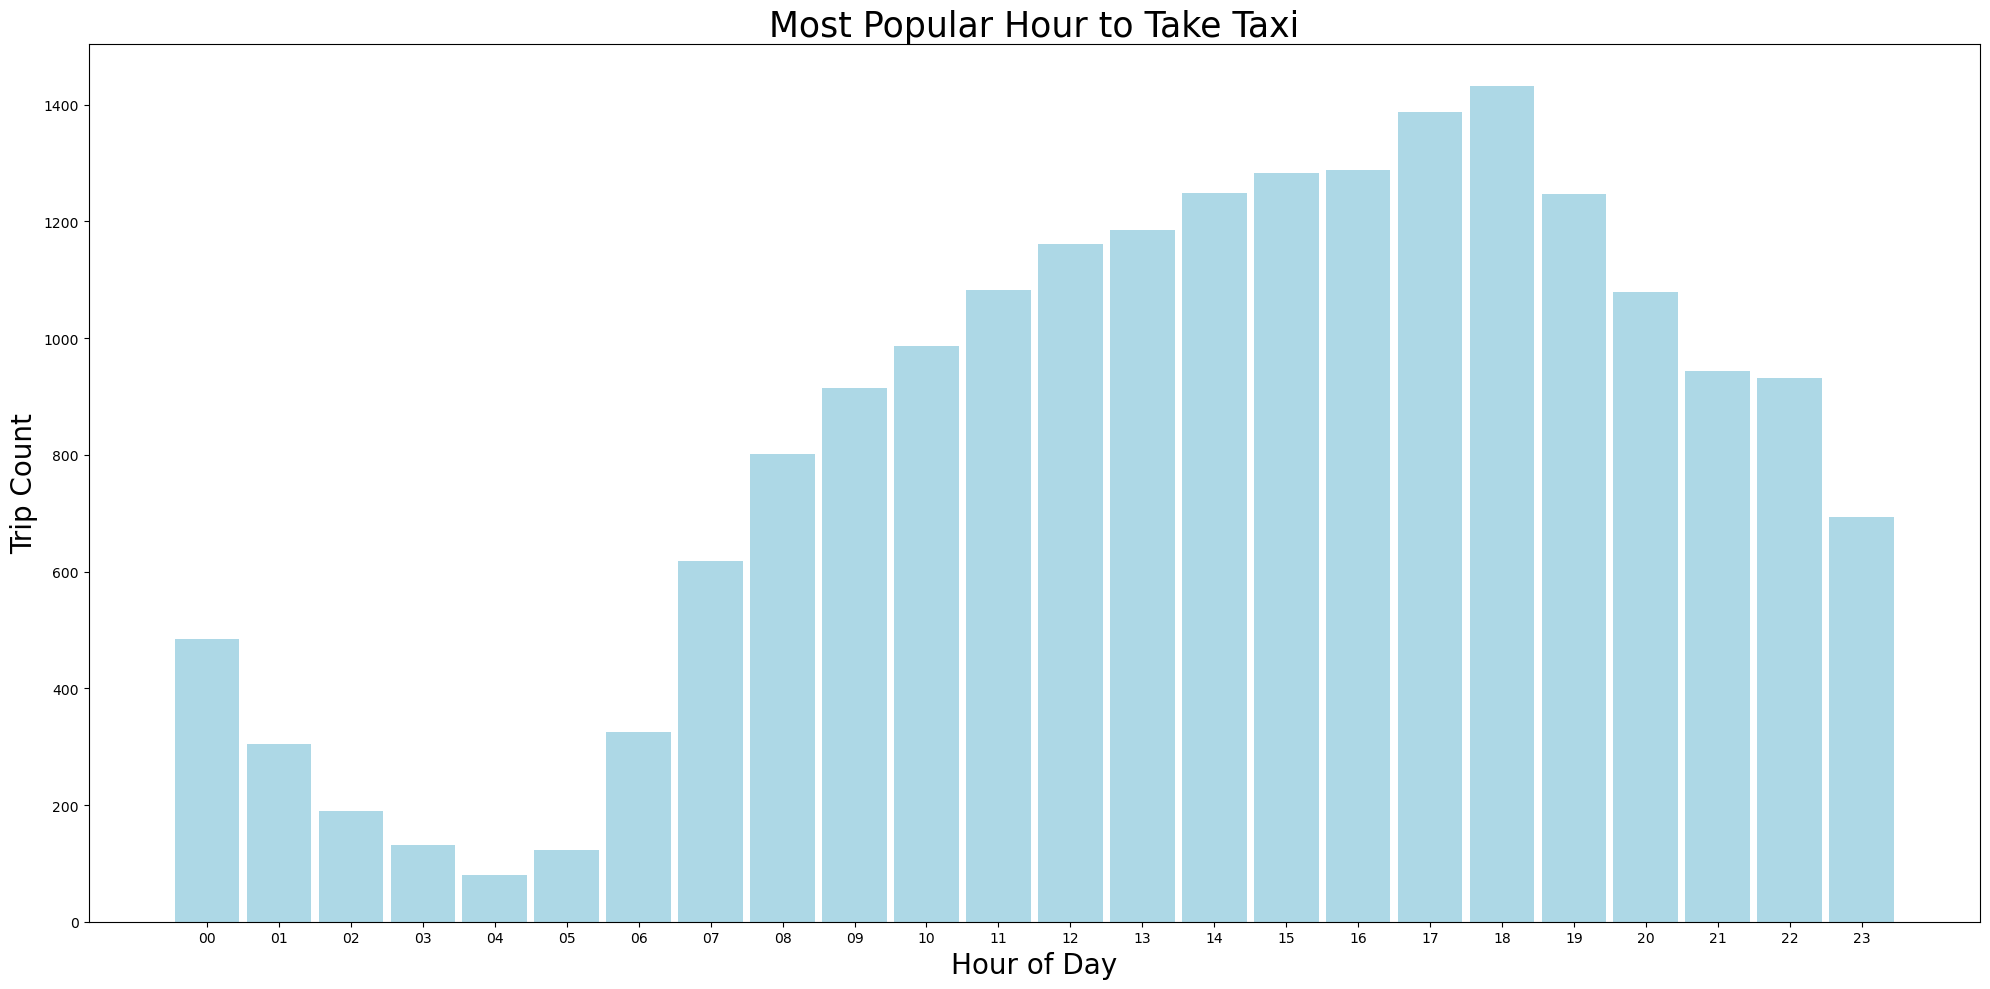

In [299]:
data_visual1 = get_data_for_visual_1()
most_popular_hour_taxi(data_visual1)

### Visualization 2 Average distance travel every month and 90% confidence interval

##### By the gragh, we can see that August and December people are travelling in longer distance, that maybe because Summer and Winter break(Chirstmas).

In [529]:
def average_distance_month(dataframe):
    dataframe['month'] = pd.to_numeric(dataframe['month'])
    dataframe.sort_values('month')
    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(dataframe['month'], dataframe['average_distance'], label='Average Distance')
    plt.fill_between(
        dataframe['month'],
        dataframe['lower_bound'],
        dataframe['upper_bound'],
        color='LightGreen',
        alpha=0.5,
        label='90% Confidence Interval'
    )
    plt.ylabel("Average Distance Traveled")
    plt.title("Average Distance Traveled per Month with 90% Confidence Interval")
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend()
    plt.grid()
    plt.show()


In [530]:
# Add bounds for the interval
def confidence_interval(dataframe):
    z_score = 1.645  # 90% confidence interval
    dataframe['std_error'] = dataframe['average_distance'] / np.sqrt(dataframe['trip_count'])
    dataframe['lower_bound'] = dataframe['average_distance'] - z_score * dataframe['std_error']
    dataframe['upper_bound'] = dataframe['average_distance'] + z_score * dataframe['std_error']
    return dataframe

In [533]:
# Get data for trip distance
def data_visual2():
    query = """
    WITH trips_combined AS (
        SELECT 
            STRFTIME('%m', pickup_time) AS month,
            trip_distance
        FROM taxi_trips
        UNION ALL
        SELECT 
            STRFTIME('%m', pickup_datetime) AS month,
            trip_miles AS trip_distance
        FROM uber_trips
    )
    SELECT 
        month,
        AVG(trip_distance) AS average_distance,
        COUNT(trip_distance) AS trip_count
    FROM trips_combined
    GROUP BY month
    ORDER BY month;
    """
    with engine.connect() as connection:
        result = pd.read_sql(query, con=connection)
    return result


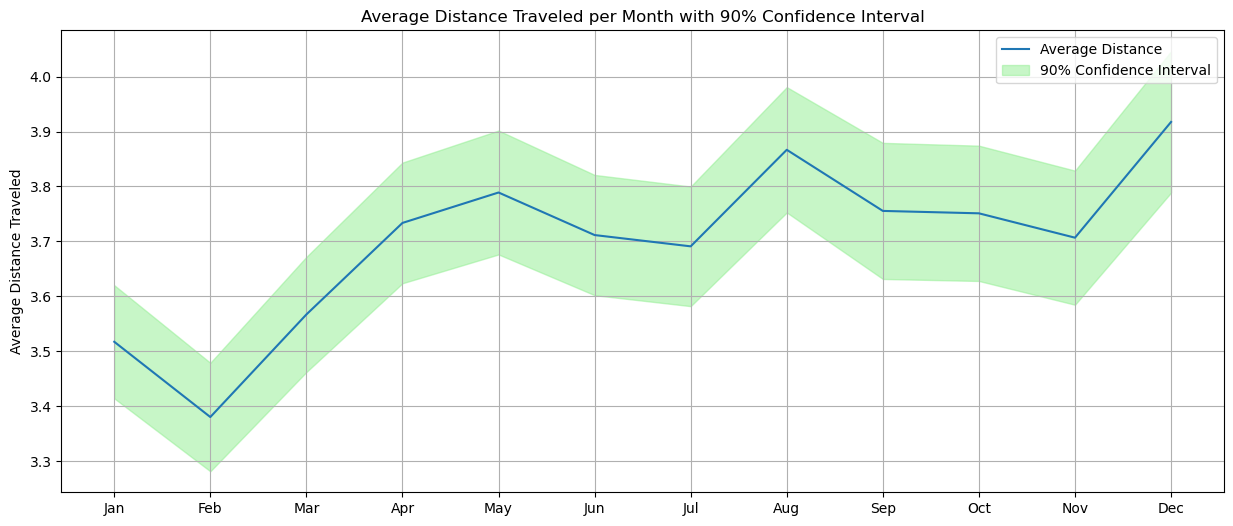

In [535]:
datav2 = data_visual2()
confidence_interval = confidence_interval(datav2)
average_distance_month(confidence_interval)


### Visualization 3 Most popular day of week for taking a ride to NYC-based airports

##### From the graph, we can see that Friday and Sunday are the two most popular day of week for taking to ride to an NYC-based airports, because peoeple on Friday may go back to their home or travel around, and people on Sunday may also go back to their living cities.

In [546]:
#get data for most popular day of week for taking a ride to an NYC-based airport
def data_visual3():
    query= """
    WITH airport_rides AS (
    SELECT 
        STRFTIME('%w', dropoff_time) AS day_of_week
    FROM taxi_trips
    WHERE 
        (
            (drop_off_lat BETWEEN 40.766267 AND 40.793183 AND drop_off_lon BETWEEN -73.889743 AND -73.852481) OR
            (drop_off_lat BETWEEN 40.633167 AND 40.651467 AND drop_off_lon BETWEEN -73.795642 AND -73.764720) OR
            (drop_off_lat BETWEEN 40.686794 AND 40.699680 AND drop_off_lon BETWEEN -74.194028 AND -74.165205)
        )
        AND dropoff_time >= '2020-01-01'
        AND dropoff_time <= '2024-08-31'
    UNION ALL
    SELECT 
        STRFTIME('%w', dropoff_datetime) AS day_of_week
    FROM uber_trips
    WHERE 
        (
            (drop_off_lat BETWEEN 40.766267 AND 40.793183 AND drop_off_lon BETWEEN -73.889743 AND -73.852481) OR
            (drop_off_lat BETWEEN 40.633167 AND 40.651467 AND drop_off_lon BETWEEN -73.795642 AND -73.764720) OR
            (drop_off_lat BETWEEN 40.686794 AND 40.699680 AND drop_off_lon BETWEEN -74.194028 AND -74.165205)
        )
        AND dropoff_datetime >= '2020-01-01'
        AND dropoff_datetime <= '2024-08-31'
    )
    SELECT 
        day_of_week,
        COUNT(*) AS total_trips
    FROM airport_rides
    GROUP BY day_of_week
    ORDER BY day_of_week;
    """

    with engine.connect() as connection:
        data = pd.read_sql(query, con=connection)
    return data


In [584]:
# Make a bar chart to display the total number of rides to the NYC aiports by day of week
def most_popular_day(data):
    day_mapping = {
        0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday',
        4: 'Thursday', 5: 'Friday', 6: 'Saturday'
    }
    data['day_of_week'] = data['day_of_week'].astype(int).map(day_mapping)
    # Plot
    plt.figure(figsize=(12, 7))
    bars=plt.bar(data['day_of_week'], data['total_trips'], color='LightGreen')
    plt.title('Number of rides to NYC-based airports by day of week')
    plt.ylabel('Number of Trips')
    for bar in bars:
        trips = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, # center of bar
            trips + 1, 
            f'{int(trips)}',  
            ha='center', 
        )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


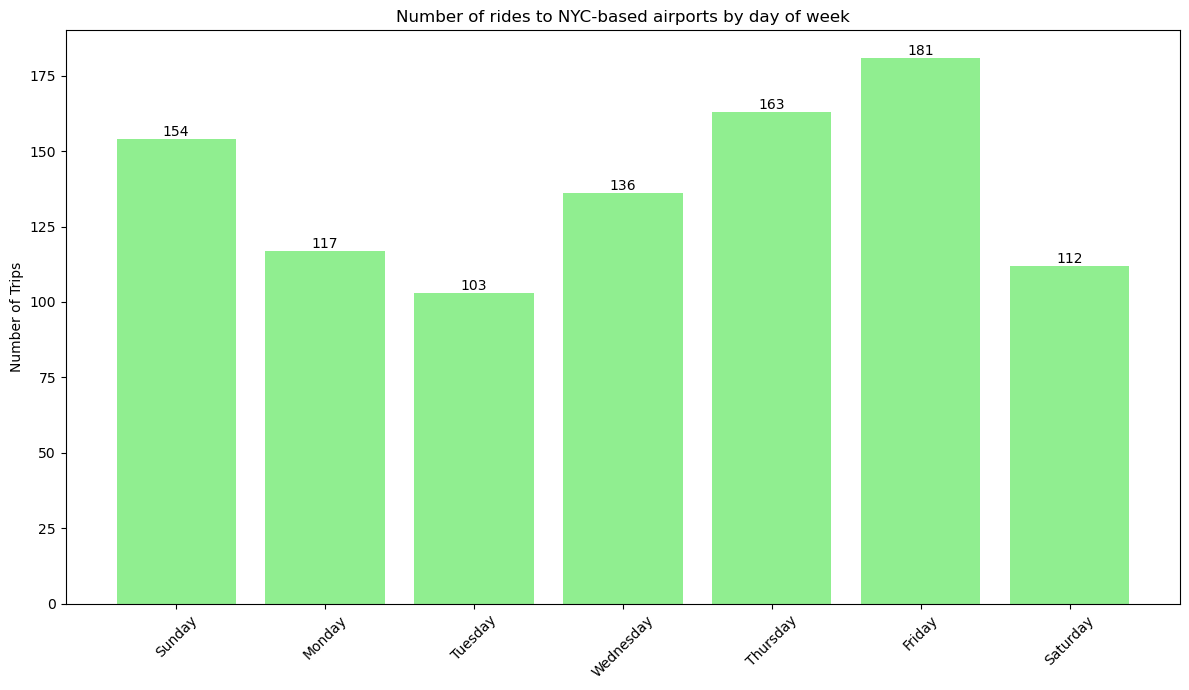

In [586]:
airport_data = data_visual3()
most_popular_day(airport_data)